In [24]:
import pandas as pd
import numpy as np

In [26]:


df = pd.read_pickle('/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/simulation_10runs.pkl')

# Now results is a DataFrame containing all the recovery info.
#df = pd.read_csv('/Users/user/PycharmProjects/PacManMain/PacTimeOrig/controllers/results/maintestsecond_slack.csv') 
#result_df = df.loc[df.groupby(['model', 'nrbf', 'opttype', 'gpscaler','tlength'])['wtcorr'].idxmax()]
#grouped_stats = result_df.groupby(['model','nrbf'])['wtcorr'].agg(['mean', 'std'])


In [27]:
df.head()
df.keys()

Index(['wtcorr_p', 'wtcorr_pv', 'wtcorr_pf', 'wtcorr_pvi', 'wtcorr_pif',
       'wtcorr_pvf', 'poscorr_p', 'poscorr_pv', 'poscorr_pf', 'poscorr_pvi',
       'poscorr_pif', 'poscorr_pvf', 'elbo_p', 'elbo_pv', 'elbo_pf',
       'elbo_pvi', 'elbo_pif', 'elbo_pvf', 'trial', 'gen_model', 'nrbfs',
       'gpscaler', 'runidx', 'real_gains', 'fit_gains', 'wtsim', 'hdi',
       'actual_shift', 'wtcorr_gen', 'poscorr_gen', 'elbo_gen', 'gaincorr_t1',
       'gaincorr_t2', 'gaincorr_all'],
      dtype='object')

/Users/assiachericoni/miniforge3/envs/ControllerPacman/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/assiachericoni/miniforge3/envs/ControllerPacman/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


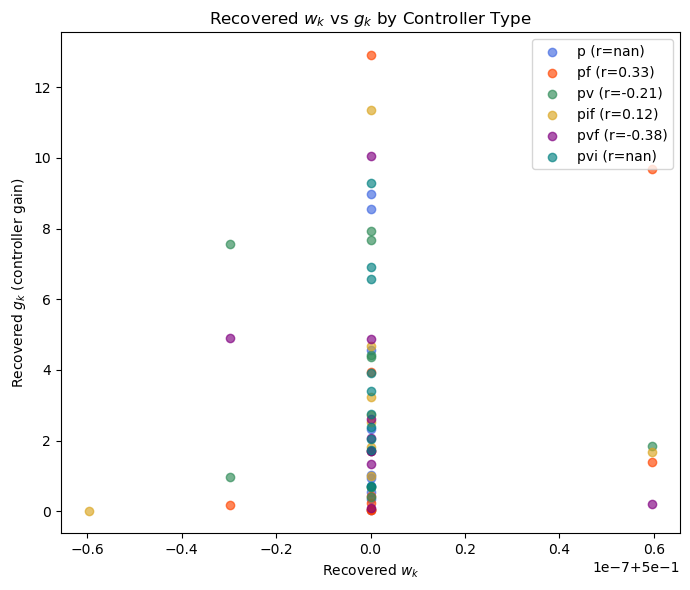

In [28]:
import matplotlib.pyplot as plt
import numpy as np

models = ['p', 'pf', 'pv', 'pif', 'pvf', 'pvi']
colors = ['royalblue', 'orangered', 'seagreen', 'goldenrod', 'purple', 'teal']

plt.figure(figsize=(7,6))

for m, color in zip(models, colors):
    recovered_wk = []
    recovered_gk = []
    for _, row in df.iterrows():
        if row.get('gen_model', None) != m:
            continue
        # Mean wt
        wt = row['wtsim']
        if isinstance(wt, (list, np.ndarray)):
            w_val = np.mean(np.array(wt).flatten())
        else:
            continue
        # Mean gain
        fit_gains = row['fit_gains']
        if isinstance(fit_gains, (list, np.ndarray)):
            g_val = np.mean(np.array(fit_gains).flatten())
        else:
            continue
        recovered_wk.append(w_val)
        recovered_gk.append(g_val)
    # Scatter plot for this controller
    if len(recovered_wk) > 1:
        r = np.corrcoef(recovered_wk, recovered_gk)[0,1]
        plt.scatter(recovered_wk, recovered_gk, alpha=0.65, color=color, label=f'{m} (r={r:.2f})')

plt.xlabel('Recovered $w_k$')
plt.ylabel('Recovered $g_k$ (controller gain)')
plt.title('Recovered $w_k$ vs $g_k$ by Controller Type')
plt.legend()
plt.tight_layout()
plt.show()


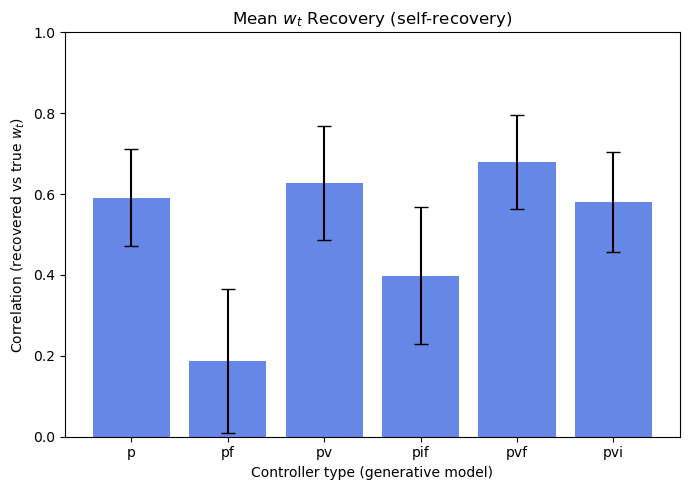

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assume your DataFrame is named df and has columns: 'gen_model', 'wtcorr_gen'
models = ['p', 'pf', 'pv', 'pif', 'pvf', 'pvi']
means = []
sems = []

for m in models:
    vals = df[df['gen_model'] == m]['wtcorr_gen'].dropna().values
    if len(vals) > 0:
        means.append(np.mean(vals))
        sems.append(np.std(vals) / np.sqrt(len(vals)))
    else:
        means.append(np.nan)
        sems.append(np.nan)

x = np.arange(len(models))
plt.figure(figsize=(7,5))
plt.bar(x, means, yerr=sems, color='royalblue', alpha=0.8, capsize=5)
plt.xticks(x, models)
plt.ylabel('Correlation (recovered vs true $w_t$)')
plt.xlabel('Controller type (generative model)')
plt.title('Mean $w_t$ Recovery (self-recovery)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


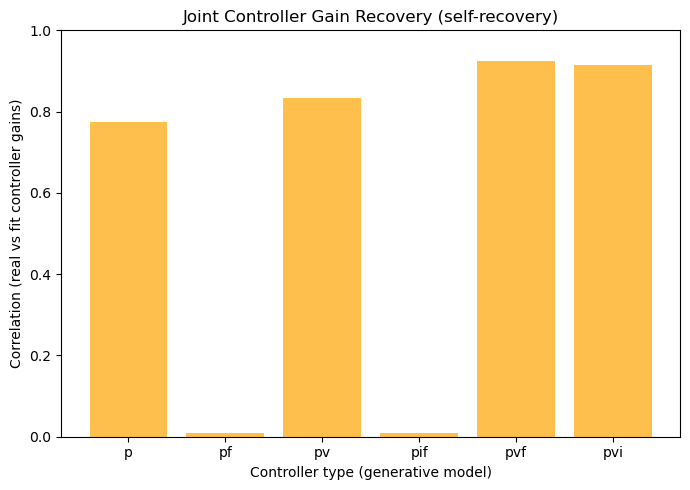

p: r=0.78
pf: r=0.01
pv: r=0.83
pif: r=0.01
pvf: r=0.92
pvi: r=0.92


In [30]:
import numpy as np
import matplotlib.pyplot as plt

models = ['p', 'pf', 'pv', 'pif', 'pvf', 'pvi']
gain_corr_means = []
gain_corr_sems = []

for m in models:
    all_real = []
    all_fit = []
    for _, row in df[df['gen_model'] == m].iterrows():
        # Handle NaN/empty
        if row['real_gains'] is None or row['fit_gains'] is None:
            continue
        # Extract and flatten real and fit gains
        real = np.array([float(x[0]) for x in row['real_gains']])
        fit  = np.array([float(x[0]) for x in row['fit_gains']])
        if len(real) == 2 and len(fit) == 2:
            all_real.extend(real)
            all_fit.extend(fit)
    # Joint correlation across all runs for this model
    if len(all_real) > 1 and len(all_fit) > 1:
        corr = np.corrcoef(all_real, all_fit)[0,1]
        gain_corr_means.append(corr)
        gain_corr_sems.append(0)   # SEM not meaningful for joint pool
    else:
        gain_corr_means.append(np.nan)
        gain_corr_sems.append(np.nan)

x = np.arange(len(models))
plt.figure(figsize=(7,5))
plt.bar(x, gain_corr_means, color='orange', alpha=0.7)
plt.xticks(x, models)
plt.ylabel('Correlation (real vs fit controller gains)')
plt.xlabel('Controller type (generative model)')
plt.title('Joint Controller Gain Recovery (self-recovery)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Print actual values for reference
for m, c in zip(models, gain_corr_means):
    print(f"{m}: r={c:.2f}")


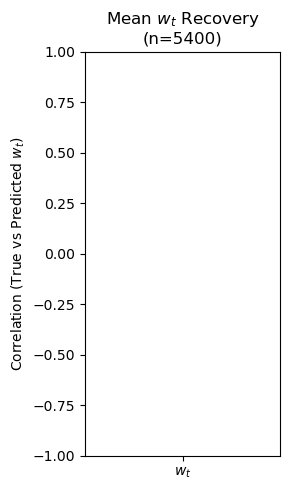

Mean: nan, SEM: nan


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get the w_t correlations for each run
wt_corrs = df['wtcorr_pvi'].values  # Replace with correct column if needed

# Compute mean and SEM
mean_corr = np.mean(wt_corrs)
sem_corr = np.std(wt_corrs) / np.sqrt(len(wt_corrs))

# Plot
plt.figure(figsize=(3, 5))
plt.bar([0], [mean_corr], yerr=[sem_corr], capsize=8, color='royalblue')
plt.ylabel("Correlation (True vs Predicted $w_t$)")
plt.title("Mean $w_t$ Recovery\n(n={})".format(len(wt_corrs)))
plt.xticks([0], ['$w_t$'])
plt.ylim(-1, 1)  # If correlations can be negative
plt.tight_layout()
plt.show()

print(f"Mean: {mean_corr:.3f}, SEM: {sem_corr:.3f}")


In [21]:
import pandas as pd
import numpy as np
import ast
# Load results
df = pd.read_pickle('/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/testAssia/controller_maintest_30runsRandom.pkl')



# Helper: turn [[array(..)], [array(..)], ...] or stringified versions into 1D float array
def flatten_gains(x):
    if isinstance(x, str):
        x = ast.literal_eval(x)
    # x is expected like: [[array([...])], [array([...])], ...] or similar
    out = []
    for item in x:
        arr = np.array(item).ravel()
        out.extend(arr.tolist())
    return np.asarray(out, dtype=float)


models = ['p', 'pv', 'pf', 'pvi', 'pif', 'pvf']

rows = []
# group by run and model so we compute one value per simulation per model
for (run, model), g in df.groupby(['run_idx', 'gen_model']):
    # choose one row per (run, model) — here: final trial
    row = g.sort_values('trial').iloc[-1]

    real = flatten_gains(row['real_gains'])
    fit  = flatten_gains(row['fit_gains'])

    if real.size == fit.size and real.size > 1 and np.isfinite(real).all() and np.isfinite(fit).all():
        r = np.corrcoef(real, fit)[0, 1]
    else:
        r = np.nan  # length=1 or mismatch ⇒ no Pearson r

    rows.append({'run_idx': run, 'model': model, 'corr_real_fit_gains': r})

corr_df = pd.DataFrame(rows)

# summary across runs
summary = (corr_df
           .groupby('model')['corr_real_fit_gains']
           .agg(mean='mean', sd='std', n='count')
           .reset_index())
summary['sem'] = summary['sd'] / np.sqrt(summary['n'].clip(lower=1))
summary['ci95_low']  = summary['mean'] - 1.96 * summary['sem']
summary['ci95_high'] = summary['mean'] + 1.96 * summary['sem']

print(summary)


  model      mean        sd   n       sem  ci95_low  ci95_high
0     p  0.400000  0.932183  30  0.170193  0.066423   0.733577
1    pf  0.125873  0.554316  30  0.101204 -0.072486   0.324233
2   pif  0.249283  0.464927  30  0.084884  0.082911   0.415655
3    pv  0.445164  0.562426  30  0.102685  0.243902   0.646426
4   pvf  0.237761  0.412215  30  0.075260  0.090252   0.385270
5   pvi  0.247385  0.484626  30  0.088480  0.073964   0.420806


In [22]:
import pandas as pd
import numpy as np
import ast

# Helper: turn [[array(..)], [array(..)], ...] or stringified versions into 1D float array
def flatten_gains(x):
    if isinstance(x, str):
        x = ast.literal_eval(x)
    # x is expected like: [[array([...])], [array([...])], ...] or similar
    out = []
    for item in x:
        arr = np.array(item).ravel()
        out.extend(arr.tolist())
    return np.asarray(out, dtype=float)

df = pd.read_pickle('/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/testAssia/controller_maintest_30runsRandom.pkl')

models = ['p', 'pv', 'pf', 'pvi', 'pif', 'pvf']

rows = []
# group by run and model so we compute one value per simulation per model
for (run, model), g in df.groupby(['run_idx', 'gen_model']):
    # choose one row per (run, model) — here: final trial
    row = g.sort_values('trial').iloc[-1]

    real = flatten_gains(row['real_gains'])
    fit  = flatten_gains(row['fit_gains'])

    if real.size == fit.size and real.size > 1 and np.isfinite(real).all() and np.isfinite(fit).all():
        r = np.corrcoef(real, fit)[0, 1]
    else:
        r = np.nan  # length=1 or mismatch ⇒ no Pearson r

    rows.append({'run_idx': run, 'model': model, 'corr_real_fit_gains': r})

corr_df = pd.DataFrame(rows)

# summary across runs
summary = (corr_df
           .groupby('model')['corr_real_fit_gains']
           .agg(mean='mean', sd='std', n='count')
           .reset_index())
summary['sem'] = summary['sd'] / np.sqrt(summary['n'].clip(lower=1))
summary['ci95_low']  = summary['mean'] - 1.96 * summary['sem']
summary['ci95_high'] = summary['mean'] + 1.96 * summary['sem']

print(summary)


  model      mean        sd   n       sem  ci95_low  ci95_high
0     p  0.400000  0.932183  30  0.170193  0.066423   0.733577
1    pf  0.125873  0.554316  30  0.101204 -0.072486   0.324233
2   pif  0.249283  0.464927  30  0.084884  0.082911   0.415655
3    pv  0.445164  0.562426  30  0.102685  0.243902   0.646426
4   pvf  0.237761  0.412215  30  0.075260  0.090252   0.385270
5   pvi  0.247385  0.484626  30  0.088480  0.073964   0.420806


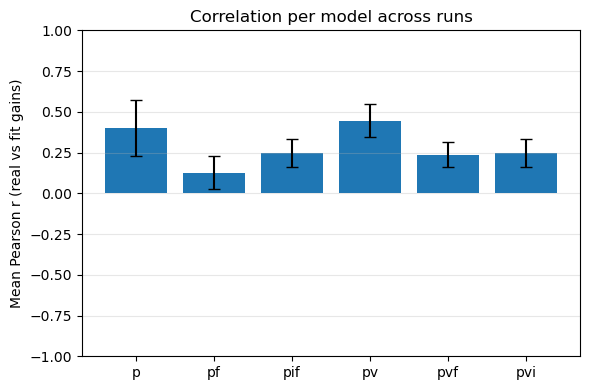

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(summary['model'], summary['mean'], yerr=summary['sem'], capsize=4)
plt.ylim(-1, 1)
plt.ylabel('Mean Pearson r (real vs fit gains)')
plt.title('Correlation per model across runs')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

